In [81]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [82]:
import numpy as np
import scipy.io
import tensorflow as tf
from tensorflow import Tensor
from tensorflow.keras import regularizers
import math

import pickle

from sinkhorn_knopp import sinkhorn_knopp as skp
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

sk = skp.SinkhornKnopp()

In [83]:
# Saving the objects:
def savingResults(name, value):
  # read all old results
  with open('saved_historys.pkl', 'rb') as f:
    allresults = pickle.load(f)
  # append new resualt
  savedvariable = {'Name' : name, 'value': value}
  allresults.append(savedvariable)
  
  # save new results
  with open('saved_historys.pkl', 'wb') as f:
    pickle.dump(allresults, f)

In [84]:
print(tf.__version__)
inputno = 4

2.2.0-rc3


In [85]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

In [86]:
def THz_RF(NRF, NTHzT, Nu):
    alpha = 3.5
    PR = 1
    fcRF = 2.1 * 10**9;
    GT = 1
    GR = 1
    c2 = (3 * 10 ** 8) ** 2
    gammaI = c2 * GT * GR / (16 * math.pi**2 * fcRF**2)
    
    PT = 1
    kf = 0.05
    fcTH = 1.0 * 10**12;
    GTT = 316.2;
    GRR = 316.2;
    thetabs = math.pi / 6
    thetamt = math.pi / 6
    FBS = thetabs / (2 * math.pi);
    FMT = thetamt / (2 * math.pi);
    gammaII = c2 * GTT * GRR / (16 * math.pi**2 * fcTH**2)
    R_max = 100
    Wt = 5 * 10^8
    Wr = 40 * 10^6
    
    rue = R_max * np.sqrt(np.random.rand(Nu,1))
    thetau = 2 * math.pi * np.random.rand(Nu,1)
    Xu = np.multiply(rue, np.cos(thetau))
    Yu = np.multiply(rue, np.sin(thetau))
    
    rTHzbs = R_max * np.sqrt(np.random.rand(NTHzT,1))
    thetaTb = 2 * math.pi * np.random.rand(NTHzT,1)
    Xb = np.multiply(rTHzbs, np.cos(thetaTb))
    Yb = np.multiply(rTHzbs, np.sin(thetaTb))
    
    rRFzbs = R_max * np.sqrt(np.random.rand(NRF,1))
    thetaRb = 2 * math.pi * np.random.rand(NRF,1)
    Xrb = np.multiply(rRFzbs, np.cos(thetaRb))
    Yrb = np.multiply(rRFzbs, np.sin(thetaRb))
    
    (Xmp_Tmat, Xp_Tmat) = np.meshgrid(Xu,Xb)
    (Ymp_Tmat, Yp_Tmat) = np.meshgrid(Yu,Yb)
    D_ue_Tbs = np.sqrt(np.power(Xmp_Tmat - Xp_Tmat, 2) + np.power(Ymp_Tmat - Yp_Tmat, 2))
    
    
    (Xmp_Rmat, Xp_Rmat) = np.meshgrid(Xu,Xrb)
    (Ymp_Rmat, Yp_Rmat) = np.meshgrid(Yu,Yrb)
    D_ue_Rbs = np.sqrt(np.power(Xmp_Rmat-Xp_Rmat, 2) + np.power(Ymp_Rmat-Yp_Rmat, 2))
    
    fadeRand = np.random.exponential(scale = 1.0, size = (NRF, Nu))
    SRF = gammaI * np.multiply(fadeRand, np.multiply(PR, np.power(D_ue_Rbs ,-alpha)))
    NP = 10 ** (-12);
    interf = np.tile(np.sum(SRF, 0), (NRF, 1)) - SRF
    RPrAllu1 = np.divide(SRF, (NP+interf))
    RPrAllu = np.divide(SRF, NP)
    
    fadeRand1 = np.random.exponential(scale = 1.0, size = (NTHzT, Nu))
    temp = np.divide(np.exp(-kf * D_ue_Tbs), np.power(D_ue_Tbs ,2))
    STHz = gammaII * np.multiply(fadeRand1, PT * temp)
    interfT = np.tile(np.sum(STHz, 0), (NTHzT, 1)) - STHz
    TPrAllu1 = np.divide(STHz, (NP+interfT))
    TPrAllu = np.divide(STHz, NP)
    
    SINR_Matrix = np.divide(1, np.concatenate((RPrAllu1, TPrAllu1), axis = 0))
    
    return SINR_Matrix

In [87]:
from scipy.optimize import linear_sum_assignment

pika = 4
RFBSs = 2
THzBSs = 2
Users=pika

Iteration = 100000;
Allcost_matrix = np.zeros(shape = (Iteration,pika,pika))
AllAssignment = np.zeros(shape = (Iteration,pika))

for i in range(Iteration):
    cost_matrix = THz_RF(RFBSs, THzBSs, Users)
#     cost_matrix = sk.fit(cost_matrix)
#     cost_matrix = np.random.rand(Users, Users)
    assignment = linear_sum_assignment(cost_matrix)[1];
    
    Allcost_matrix[i,:,:] = cost_matrix
    AllAssignment[i,:] = assignment

In [125]:
Train_percentage = 0.9
Val_percentage = 0.1

x_data = np.expand_dims(Allcost_matrix,axis = 3)

# x_data = 1/(np.log10(x_data + 1))
x_data = np.log10(x_data) - 1
# x_data = x_data - 0.5
# x_data = 2*x_data

y_data = np.expand_dims(AllAssignment[:,0],axis = 1)


Total_data_No = y_data.shape[0]
#Val_No = int(np.floor(Val_percentage*Total_data_No))
Train_data_No = int(np.floor(Train_percentage*Total_data_No))
# print(Total_data_No)
# print(Train_data_No)
y_test = y_data[Train_data_No:,:]
y_train2 = y_data[:Train_data_No,:]


x_test = x_data[Train_data_No:,:,:,:]
x_train2 = x_data[:Train_data_No,:,:,:]

In [126]:
def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size= kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    # y = relu_bn(y)
    y = ReLU()(y)
    
    y = Conv2D(kernel_size= kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)
               
    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    # out = relu_bn(out)
    out = ReLU()(out)
    return out

In [133]:
def create_res_net():
    
    inputs = Input(shape=(inputno, inputno, 1))
    num_filters = 32
    
    #t = BatchNormalization()(inputs)
    #t = Conv2D(kernel_size=3,
               #strides=1,
               #filters=num_filters,
               #padding="same")(inputs)
    #t = relu_bn(t)
    #t= ReLU()(t)
    t = inputs
    num_blocks_list = [2]
    for i in range(len(num_blocks_list)):
      num_blocks = num_blocks_list[i]
      for j in range(num_blocks):
        t = residual_block(t, downsample= (j==0 and i!=0), filters=num_filters)
        t = Dropout(0.1)(t)
      num_filters *= 2
    #num_filters1 = 16
    #num_filters2 = 16
    #t = residual_block(t, downsample=(False), filters=num_filters1)
    #t = residual_block(t, downsample=(False), filters=num_filters2)

    
    #t = AveragePooling2D(4)(t)
    t = Flatten()(t)
#     t = Dropout(0.2)(t)
#     m = Dense(32,activation = 'softmax')(t)
#     t = Dropout(0.2)(t)
    outputs = Dense(inputno, activation='softmax')(t)
    
    model = Model(inputs, outputs)
    myopt = tf.keras.optimizers.Adam(
      learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
      name='Adam'
                            )
    model.compile(
        optimizer= myopt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [134]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
import os


model = create_res_net() 
model.summary()

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
name = 'Association'+timestr 

checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.system('mkdir {}'.format(checkpoint_dir))

# save model after each epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1
)
tensorboard_callback = TensorBoard(
    log_dir='tensorboard_logs/'+name,
    histogram_freq=1
)

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 4, 4, 1)]    0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 4, 4, 32)     320         input_25[0][0]                   
__________________________________________________________________________________________________
re_lu_95 (ReLU)                 (None, 4, 4, 32)     0           conv2d_96[0][0]                  
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 4, 4, 32)     9248        re_lu_95[0][0]                   
___________________________________________________________________________________________

Epoch 1/700
704/704 [==============================] - 5s 6ms/step - loss: 1.4104 - accuracy: 0.3676 - val_loss: 1.1548 - val_accuracy: 0.5106
Epoch 2/700
704/704 [==============================] - 5s 6ms/step - loss: 1.2027 - accuracy: 0.4766 - val_loss: 1.0374 - val_accuracy: 0.5939
Epoch 3/700
704/704 [==============================] - 5s 6ms/step - loss: 1.1049 - accuracy: 0.5336 - val_loss: 0.9549 - val_accuracy: 0.6321
Epoch 4/700
704/704 [==============================] - 5s 7ms/step - loss: 1.0239 - accuracy: 0.5747 - val_loss: 0.8775 - val_accuracy: 0.6643
Epoch 5/700
704/704 [==============================] - 5s 7ms/step - loss: 0.9476 - accuracy: 0.6072 - val_loss: 0.8092 - val_accuracy: 0.6823
Epoch 6/700
704/704 [==============================] - 5s 7ms/step - loss: 0.8844 - accuracy: 0.6314 - val_loss: 0.7560 - val_accuracy: 0.7000
Epoch 7/700
704/704 [==============================] - 5s 7ms/step - loss: 0.8400 - accuracy: 0.6471 - val_loss: 0.7171 - val_accuracy: 0.7098

Epoch 58/700
704/704 [==============================] - 5s 7ms/step - loss: 0.4561 - accuracy: 0.8054 - val_loss: 0.4056 - val_accuracy: 0.8299
Epoch 59/700
704/704 [==============================] - 5s 7ms/step - loss: 0.4538 - accuracy: 0.8058 - val_loss: 0.4035 - val_accuracy: 0.8323
Epoch 60/700
704/704 [==============================] - 5s 7ms/step - loss: 0.4520 - accuracy: 0.8064 - val_loss: 0.4019 - val_accuracy: 0.8330
Epoch 61/700
704/704 [==============================] - 5s 7ms/step - loss: 0.4475 - accuracy: 0.8101 - val_loss: 0.3988 - val_accuracy: 0.8349
Epoch 62/700
704/704 [==============================] - 5s 7ms/step - loss: 0.4476 - accuracy: 0.8096 - val_loss: 0.3978 - val_accuracy: 0.8353
Epoch 63/700
704/704 [==============================] - 5s 7ms/step - loss: 0.4445 - accuracy: 0.8110 - val_loss: 0.3956 - val_accuracy: 0.8352
Epoch 64/700
704/704 [==============================] - 5s 7ms/step - loss: 0.4440 - accuracy: 0.8109 - val_loss: 0.3932 - val_accuracy:

Epoch 115/700
704/704 [==============================] - 5s 7ms/step - loss: 0.3598 - accuracy: 0.8502 - val_loss: 0.3160 - val_accuracy: 0.8747
Epoch 116/700
704/704 [==============================] - 5s 7ms/step - loss: 0.3584 - accuracy: 0.8496 - val_loss: 0.3152 - val_accuracy: 0.8740
Epoch 117/700
704/704 [==============================] - 5s 7ms/step - loss: 0.3555 - accuracy: 0.8516 - val_loss: 0.3139 - val_accuracy: 0.8745
Epoch 118/700
704/704 [==============================] - 5s 7ms/step - loss: 0.3553 - accuracy: 0.8508 - val_loss: 0.3128 - val_accuracy: 0.8749
Epoch 119/700
704/704 [==============================] - 5s 7ms/step - loss: 0.3527 - accuracy: 0.8545 - val_loss: 0.3111 - val_accuracy: 0.8761
Epoch 120/700
704/704 [==============================] - 5s 7ms/step - loss: 0.3523 - accuracy: 0.8527 - val_loss: 0.3101 - val_accuracy: 0.8756
Epoch 121/700
704/704 [==============================] - 5s 7ms/step - loss: 0.3517 - accuracy: 0.8533 - val_loss: 0.3095 - val_ac

704/704 [==============================] - 5s 7ms/step - loss: 0.3094 - accuracy: 0.8724 - val_loss: 0.2712 - val_accuracy: 0.8938
Epoch 172/700
704/704 [==============================] - 5s 7ms/step - loss: 0.3103 - accuracy: 0.8722 - val_loss: 0.2715 - val_accuracy: 0.8939
Epoch 173/700
704/704 [==============================] - 5s 7ms/step - loss: 0.3086 - accuracy: 0.8721 - val_loss: 0.2710 - val_accuracy: 0.8941
Epoch 174/700
704/704 [==============================] - 5s 7ms/step - loss: 0.3093 - accuracy: 0.8730 - val_loss: 0.2694 - val_accuracy: 0.8952
Epoch 175/700
704/704 [==============================] - 5s 7ms/step - loss: 0.3075 - accuracy: 0.8727 - val_loss: 0.2693 - val_accuracy: 0.8942
Epoch 176/700
704/704 [==============================] - 5s 7ms/step - loss: 0.3080 - accuracy: 0.8726 - val_loss: 0.2687 - val_accuracy: 0.8946
Epoch 177/700
704/704 [==============================] - 5s 7ms/step - loss: 0.3049 - accuracy: 0.8745 - val_loss: 0.2682 - val_accuracy: 0.8944

704/704 [==============================] - 5s 7ms/step - loss: 0.2800 - accuracy: 0.8848 - val_loss: 0.2455 - val_accuracy: 0.9049
Epoch 228/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2793 - accuracy: 0.8846 - val_loss: 0.2454 - val_accuracy: 0.9052
Epoch 229/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2786 - accuracy: 0.8853 - val_loss: 0.2445 - val_accuracy: 0.9063
Epoch 230/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2788 - accuracy: 0.8849 - val_loss: 0.2441 - val_accuracy: 0.9068
Epoch 231/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2795 - accuracy: 0.8848 - val_loss: 0.2444 - val_accuracy: 0.9046
Epoch 232/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2780 - accuracy: 0.8862 - val_loss: 0.2433 - val_accuracy: 0.9054
Epoch 233/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2761 - accuracy: 0.8872 - val_loss: 0.2431 - val_accuracy: 0.9052

704/704 [==============================] - 5s 7ms/step - loss: 0.2564 - accuracy: 0.8957 - val_loss: 0.2277 - val_accuracy: 0.9116
Epoch 284/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2572 - accuracy: 0.8946 - val_loss: 0.2267 - val_accuracy: 0.9125
Epoch 285/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2555 - accuracy: 0.8947 - val_loss: 0.2272 - val_accuracy: 0.9114
Epoch 286/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2558 - accuracy: 0.8946 - val_loss: 0.2267 - val_accuracy: 0.9122
Epoch 287/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2548 - accuracy: 0.8956 - val_loss: 0.2263 - val_accuracy: 0.9125
Epoch 288/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2549 - accuracy: 0.8955 - val_loss: 0.2263 - val_accuracy: 0.9113
Epoch 289/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2564 - accuracy: 0.8949 - val_loss: 0.2263 - val_accuracy: 0.9129

704/704 [==============================] - 6s 8ms/step - loss: 0.2386 - accuracy: 0.9023 - val_loss: 0.2135 - val_accuracy: 0.9167
Epoch 340/700
704/704 [==============================] - 5s 8ms/step - loss: 0.2380 - accuracy: 0.9025 - val_loss: 0.2127 - val_accuracy: 0.9159
Epoch 341/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2390 - accuracy: 0.9024 - val_loss: 0.2127 - val_accuracy: 0.9170
Epoch 342/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2379 - accuracy: 0.9024 - val_loss: 0.2128 - val_accuracy: 0.9164
Epoch 343/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2374 - accuracy: 0.9029 - val_loss: 0.2128 - val_accuracy: 0.9152
Epoch 344/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2374 - accuracy: 0.9016 - val_loss: 0.2123 - val_accuracy: 0.9158
Epoch 345/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2370 - accuracy: 0.9027 - val_loss: 0.2119 - val_accuracy: 0.9170

704/704 [==============================] - 6s 8ms/step - loss: 0.2241 - accuracy: 0.9072 - val_loss: 0.2018 - val_accuracy: 0.9199
Epoch 396/700
704/704 [==============================] - 5s 8ms/step - loss: 0.2247 - accuracy: 0.9069 - val_loss: 0.2013 - val_accuracy: 0.9199
Epoch 397/700
704/704 [==============================] - 5s 8ms/step - loss: 0.2234 - accuracy: 0.9084 - val_loss: 0.2018 - val_accuracy: 0.9202
Epoch 398/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2224 - accuracy: 0.9085 - val_loss: 0.2014 - val_accuracy: 0.9199
Epoch 399/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2228 - accuracy: 0.9084 - val_loss: 0.2011 - val_accuracy: 0.9196
Epoch 400/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2222 - accuracy: 0.9092 - val_loss: 0.2003 - val_accuracy: 0.9206
Epoch 401/700
704/704 [==============================] - 5s 8ms/step - loss: 0.2215 - accuracy: 0.9091 - val_loss: 0.2003 - val_accuracy: 0.9201

704/704 [==============================] - 5s 7ms/step - loss: 0.2102 - accuracy: 0.9144 - val_loss: 0.1930 - val_accuracy: 0.9237
Epoch 452/700
704/704 [==============================] - 6s 9ms/step - loss: 0.2110 - accuracy: 0.9134 - val_loss: 0.1918 - val_accuracy: 0.9245
Epoch 453/700
704/704 [==============================] - 6s 9ms/step - loss: 0.2100 - accuracy: 0.9136 - val_loss: 0.1917 - val_accuracy: 0.9242
Epoch 454/700
704/704 [==============================] - 6s 8ms/step - loss: 0.2110 - accuracy: 0.9133 - val_loss: 0.1915 - val_accuracy: 0.9244
Epoch 455/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2094 - accuracy: 0.9141 - val_loss: 0.1910 - val_accuracy: 0.9244
Epoch 456/700
704/704 [==============================] - 5s 7ms/step - loss: 0.2105 - accuracy: 0.9130 - val_loss: 0.1912 - val_accuracy: 0.9236
Epoch 457/700
704/704 [==============================] - 5s 8ms/step - loss: 0.2105 - accuracy: 0.9134 - val_loss: 0.1911 - val_accuracy: 0.9252

704/704 [==============================] - 6s 9ms/step - loss: 0.2009 - accuracy: 0.9174 - val_loss: 0.1842 - val_accuracy: 0.9276
Epoch 508/700
704/704 [==============================] - 6s 8ms/step - loss: 0.2004 - accuracy: 0.9177 - val_loss: 0.1842 - val_accuracy: 0.9279
Epoch 509/700
704/704 [==============================] - 6s 8ms/step - loss: 0.2006 - accuracy: 0.9183 - val_loss: 0.1840 - val_accuracy: 0.9280
Epoch 510/700
704/704 [==============================] - 5s 8ms/step - loss: 0.1983 - accuracy: 0.9190 - val_loss: 0.1835 - val_accuracy: 0.9278
Epoch 511/700
704/704 [==============================] - 6s 8ms/step - loss: 0.1993 - accuracy: 0.9183 - val_loss: 0.1835 - val_accuracy: 0.9282
Epoch 512/700
704/704 [==============================] - 6s 8ms/step - loss: 0.2007 - accuracy: 0.9175 - val_loss: 0.1835 - val_accuracy: 0.9277
Epoch 513/700
704/704 [==============================] - 6s 8ms/step - loss: 0.2005 - accuracy: 0.9178 - val_loss: 0.1832 - val_accuracy: 0.9287

704/704 [==============================] - 6s 8ms/step - loss: 0.1930 - accuracy: 0.9207 - val_loss: 0.1774 - val_accuracy: 0.9294
Epoch 564/700
704/704 [==============================] - 6s 9ms/step - loss: 0.1945 - accuracy: 0.9208 - val_loss: 0.1779 - val_accuracy: 0.9290
Epoch 565/700
704/704 [==============================] - 6s 9ms/step - loss: 0.1911 - accuracy: 0.9215 - val_loss: 0.1774 - val_accuracy: 0.9292
Epoch 566/700
704/704 [==============================] - 6s 8ms/step - loss: 0.1904 - accuracy: 0.9218 - val_loss: 0.1769 - val_accuracy: 0.9305
Epoch 567/700
704/704 [==============================] - 6s 8ms/step - loss: 0.1921 - accuracy: 0.9208 - val_loss: 0.1772 - val_accuracy: 0.9300
Epoch 568/700
704/704 [==============================] - 6s 8ms/step - loss: 0.1908 - accuracy: 0.9212 - val_loss: 0.1769 - val_accuracy: 0.9300
Epoch 569/700
704/704 [==============================] - 6s 9ms/step - loss: 0.1902 - accuracy: 0.9226 - val_loss: 0.1770 - val_accuracy: 0.9300

704/704 [==============================] - 5s 7ms/step - loss: 0.1835 - accuracy: 0.9247 - val_loss: 0.1718 - val_accuracy: 0.9323
Epoch 620/700
704/704 [==============================] - 5s 8ms/step - loss: 0.1824 - accuracy: 0.9249 - val_loss: 0.1722 - val_accuracy: 0.9315
Epoch 621/700
704/704 [==============================] - 5s 8ms/step - loss: 0.1824 - accuracy: 0.9250 - val_loss: 0.1715 - val_accuracy: 0.9314
Epoch 622/700
704/704 [==============================] - 5s 7ms/step - loss: 0.1826 - accuracy: 0.9255 - val_loss: 0.1718 - val_accuracy: 0.9319
Epoch 623/700
704/704 [==============================] - 5s 7ms/step - loss: 0.1823 - accuracy: 0.9256 - val_loss: 0.1714 - val_accuracy: 0.9326
Epoch 624/700
704/704 [==============================] - 5s 7ms/step - loss: 0.1828 - accuracy: 0.9253 - val_loss: 0.1713 - val_accuracy: 0.9317
Epoch 625/700
704/704 [==============================] - 5s 8ms/step - loss: 0.1822 - accuracy: 0.9264 - val_loss: 0.1707 - val_accuracy: 0.9327

704/704 [==============================] - 5s 7ms/step - loss: 0.1766 - accuracy: 0.9273 - val_loss: 0.1665 - val_accuracy: 0.9342
Epoch 676/700
704/704 [==============================] - 5s 7ms/step - loss: 0.1746 - accuracy: 0.9279 - val_loss: 0.1667 - val_accuracy: 0.9332
Epoch 677/700
704/704 [==============================] - 5s 7ms/step - loss: 0.1764 - accuracy: 0.9279 - val_loss: 0.1670 - val_accuracy: 0.9336
Epoch 678/700
704/704 [==============================] - 5s 7ms/step - loss: 0.1763 - accuracy: 0.9275 - val_loss: 0.1664 - val_accuracy: 0.9344
Epoch 679/700
704/704 [==============================] - 5s 7ms/step - loss: 0.1758 - accuracy: 0.9282 - val_loss: 0.1660 - val_accuracy: 0.9340
Epoch 680/700
704/704 [==============================] - 5s 7ms/step - loss: 0.1755 - accuracy: 0.9275 - val_loss: 0.1661 - val_accuracy: 0.9342
Epoch 681/700
704/704 [==============================] - 5s 7ms/step - loss: 0.1759 - accuracy: 0.9281 - val_loss: 0.1664 - val_accuracy: 0.9346

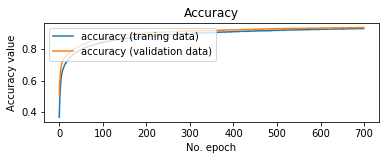

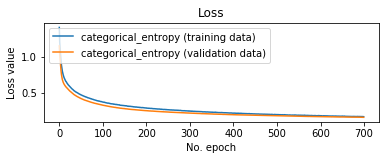

In [135]:
history = model.fit(
    x=x_train2,
    y=y_train2,
    epochs=700,
    verbose=1,
    validation_data=(x_test, y_test),
    batch_size=128,
#     callbacks=[cp_callback, tensorboard_callback]
    
)
savingResults(name = 'ResNet4', value = history.history)

import matplotlib.pyplot as plt

# Plot history: MAE
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy (traning data)')
plt.plot(history.history['val_accuracy'], label='accuracy (validation data)')
plt.title('Accuracy')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='categorical_entropy (training data)')
plt.plot(history.history['val_loss'], label='categorical_entropy (validation data)')
plt.title('Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
%tensorboard --logdir tensorboard_logs

In [139]:
savingResults(name = 'ResNet4', value = history.history)